In [94]:
import json
import pandas as pd
import random
import numpy as np
import bcolz
import os
from tifffile import imread
from glob import glob
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from catboost import CatBoostClassifier

from scipy.stats import rankdata

from tqdm.notebook import tqdm

import geohash
import geopandas as gpd

import matplotlib.pyplot as plt

import helpers
from helpers import get_labels, plot_, get_metrics, get_conf, plot_map, get_confusion_metrics, get_conf, plot_heatmap_nomap, plot_heatmap
from helpers import get_locusthub_df, polygon2geohash

import importlib
importlib.reload(helpers)

import ee
ee.Initialize()

# Create download list

In [95]:
import urllib.request

base_dir = '/home/ebarnett/locusts/'
url = 'https://datahub.io/core/airport-codes/r/airport-codes.csv'
urllib.request.urlretrieve(url, os.path.join(base_dir, 'airport-codes.csv'))
df = pd.read_csv(os.path.join(base_dir, 'airport-codes.csv'))
df = df.loc[df['iso_country'] == 'ET']
df[['X', 'Y']] = df['coordinates'].str.split(', ', expand=True)
df['X'] = pd.to_numeric(df['X'])
df['Y'] = pd.to_numeric(df['Y'])
df['geohash'] = df[['Y', 'X']].apply(lambda x: geohash.encode(*x, precision=5), axis=1).values


airport_ghs = set(df['geohash'])

for _ in range(5):
    for g in list(airport_ghs):
        airport_ghs |= set(geohash.expand(g))

country_geojson = '/home/ebarnett/naip_collect/geojson/countries/ETH.geo.json'
country = json.load(open(country_geojson))['features'][0]
polygon = ee.Geometry.Polygon(country['geometry']['coordinates'])
geohashes_country = polygon2geohash(polygon, precision=5, coarse_precision=5)
start_date = '2019-01-01'
end_date = '2020-01-01'

geohashes_country = random.sample(geohashes_country, int(len(geohashes_country)/5))
geohashes_country.extend(airport_ghs)
geohahses_country = list(set(geohashes_country))

dl_list = []
for gh in geohashes_country:
    dl_list.append({'date_start': start_date, 
                    'date_end': end_date, 
                    'geohash': gh})

with open('/home/ebarnett/naip_collect/airports_eth_dl_list.json', 'w') as f:
    json.dump(dl_list, f)
    

In [96]:
# Download with /home/ebarnett/locusts/download_imagery/date_geohash.py, 
# Featurize with /home/ebarnett/rs_visiontools/main_featurize.py


# Get Embeddings

In [140]:
df_meta = pd.read_csv('/raid/users/ebarnett/eth_airports_fts/meta_0.csv')
Xn_orig = np.array(bcolz.open('/raid/users/ebarnett/eth_airports_fts/embs_0'))


# Normalize
Xn = Xn_orig / np.sqrt((Xn_orig ** 2).sum(axis=-1, keepdims=True))

# Remove corrupted if exist
drop_idx = np.unique(np.argwhere(np.isnan(Xn))[:,0])
Xn = np.delete(Xn, drop_idx, axis=0)
df_meta = df_meta.drop(drop_idx).reset_index(drop=True)

# Add missing info
df_meta['date'] = pd.to_datetime(df_meta.date)
df_meta['lat'] = df_meta.apply(lambda rec: geohash.decode(rec['geohash'])[1], axis=1)
df_meta['lon'] = df_meta.apply(lambda rec: geohash.decode(rec['geohash'])[0], axis=1)
df_meta = df_meta[['path', 'date', 'geohash', 'lat', 'lon']]


# Get Airport Labels

In [156]:
import urllib.request

base_dir = '/home/ebarnett/locusts/'
url = 'https://datahub.io/core/airport-codes/r/airport-codes.csv'
urllib.request.urlretrieve(url, os.path.join(base_dir, 'airport-codes.csv'))
df = pd.read_csv(os.path.join(base_dir, 'airport-codes.csv'))
df = df.loc[df['iso_country'] == 'ET'].loc[df['type'] != 'closed']#.loc[df['municipality'] != 'Addis Ababa']
df[['X', 'Y']] = df['coordinates'].str.split(', ', expand=True)
df['X'] = pd.to_numeric(df['X'])
df['Y'] = pd.to_numeric(df['Y'])
df['geohash'] = df[['Y', 'X']].apply(lambda x: geohash.encode(*x, precision=5), axis=1).values

df_label = df_meta.copy()
df_label['airport'] = df_label['geohash'].isin(list(df['geohash'].unique()))
y = np.array(df_label['airport']).astype(np.int32)
df

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,X,Y,geohash
20209,ET-0002,small_airport,Kibbish Wells Airport,1403.0,AF,ET,ET-SN,Kibbish Wells,NaN,NaN,NaN,"35.8682, 5.296",35.868200,5.296000,sbcw0
20210,ET-0003,small_airport,Ganada Airport,NaN,AF,ET,ET-SN,NaN,NaN,NaN,NaN,"37.022991, 5.337166",37.022991,5.337166,sbfq6
20211,ET-GLC,small_airport,Geladi Airport,1383.0,AF,ET,ET-SO,Geladi,HAGL,GLC,NaN,"46.4213981628, 6.984439849849999",46.421398,6.984440,t11p8
20212,ET-SHC,small_airport,Shire Inda Selassie Airport,6207.0,AF,ET,ET-TI,Shire Indasilase,NaN,SHC,NaN,"38.272499084472656, 14.078100204467773",38.272499,14.078100,sfe0n
23733,HAAB,large_airport,Addis Ababa Bole International Airport,7630.0,AF,ET,ET-AA,Addis Ababa,HAAB,ADD,NaN,"38.799301147499996, 8.97789001465",38.799301,8.977890,scee4
23734,HAAD,small_airport,Adaba Airport,7896.0,AF,ET,ET-OR,Adaba,HAAD,NaN,NaN,"39.400001525878906, 7.050000190734863",39.400002,7.050000,sck00
23735,HAAL,small_airport,Lideta Army Airport,7749.0,AF,ET,ET-AA,Addis Ababa,HAAL,NaN,NaN,"38.725498, 9.003685",38.725498,9.003685,scee1
23736,HAAM,medium_airport,Arba Minch Airport,3901.0,AF,ET,ET-SN,NaN,HAAM,AMH,NaN,"37.59049987792969, 6.0393900871276855",37.590500,6.039390,sc4dr
23737,HAAX,medium_airport,Axum Airport,6959.0,AF,ET,ET-TI,NaN,HAAX,AXU,NaN,"38.77280044555664, 14.14680004119873",38.772800,14.146800,sfe86
23738,HABC,small_airport,Baco Airport,4580.0,AF,ET,ET-SN,Baco,HABC,BCO,NaN,"36.562, 5.78287",36.562000,5.782870,sc1bz


# Baseline SVM experiment

In [ ]:
idx = np.arange(len(df_label))
X_train, X_valid, y_train, y_valid, idx_train, idx_valid = train_test_split(Xn, y, idx,
                                                           train_size=0.5, 
                                                           stratify=y, 
                                                           random_state=1)

df_valid = df_label.iloc[idx_valid]
df_train = df_label.iloc[idx_train]

from sklearn.ensemble import RandomForestClassifier

model = LinearSVC().fit(X_train, y_train)
pred_valid = model.decision_function(X_valid)

roc_auc = metrics.roc_auc_score(y_valid, pred_valid)
metrics_dict = get_metrics(pred_valid, y_valid, thresh=0.5)

print(roc_auc, metrics_dict)

df_valid = df_label.iloc[idx_valid]
df_valid['pred_valid'] = pred_valid
df_valid.sort_values('pred_valid')[-10::]

# Distance for single hash

In [145]:
from scipy.spatial import distance

gh = 'scwmm'
idx_train = df_label.loc[df_label['geohash'] == gh].index
idx_valid = df_label.loc[df_label['geohash'] != gh].index

df_valid = df_label.iloc[idx_valid]
df_train = df_label.iloc[idx_train]

dis = []
for i in tqdm(idx_valid):
    dis.append(distance.cosine(Xn[idx_train], Xn[i]))

df_valid['dist'] = dis
df_valid.sort_values('dist')


,path,date,geohash,lat,lon,airport,dist
1989,/raid/users/ebarnett/eth_airports/scwjr_2019-0...,2019-01-01,scwjr,42.517090,9.382324,False,0.021412
1766,/raid/users/ebarnett/eth_airports/scwmj_2019-0...,2019-01-01,scwmj,42.780762,9.338379,False,0.023269
13735,/raid/users/ebarnett/eth_airports/scwdg_2019-0...,2019-01-01,scwdg,43.044434,8.942871,False,0.024028
12814,/raid/users/ebarnett/eth_airports/scwmq_2019-0...,2019-01-01,scwmq,42.824707,9.382324,False,0.024561
5093,/raid/users/ebarnett/eth_airports/scw9x_2019-0...,2019-01-01,scw9x,43.220215,8.723145,False,0.025313
...,...,...,...,...,...,...,...
13977,/raid/users/ebarnett/eth_airports/sc4f9_2019-0...,2019-01-01,sc4f9,37.683105,6.086426,False,0.656253
7838,/raid/users/ebarnett/eth_airports/sc4f8_2019-0...,2019-01-01,sc4f8,37.639160,6.086426,False,0.656877
12864,/raid/users/ebarnett/eth_airports/sc4f2_2019-0...,2019-01-01,sc4f2,37.639160,6.042480,False,0.657560
10744,/raid/users/ebarnett/eth_airports/sc5j0_2019-0...,2019-01-01,sc5j0,37.990723,6.525879,False,0.662309


# Imagery

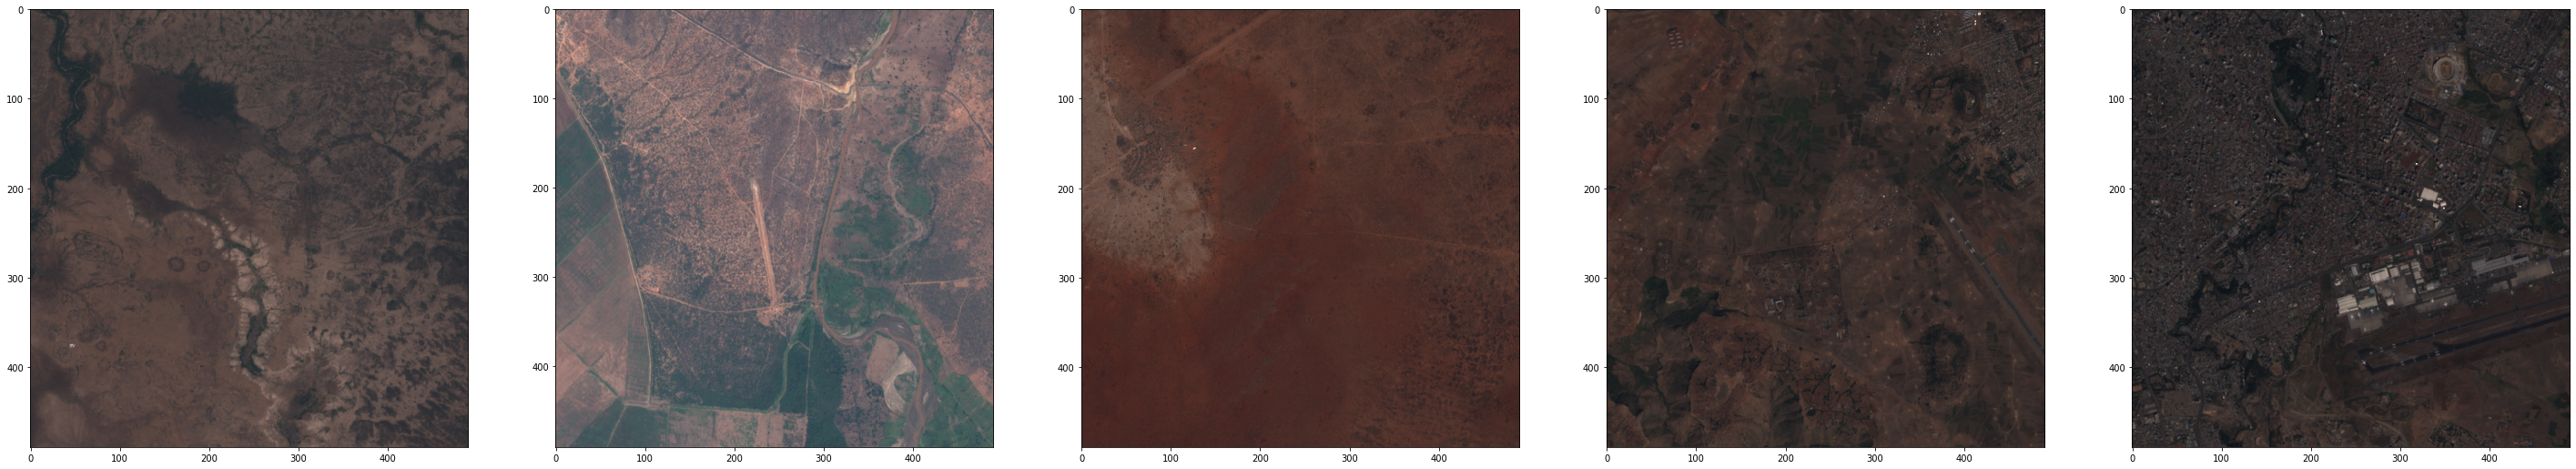

In [157]:
def get_sentinel_img(path, ghash):
    with ZipFile(path) as handle:
        tile = np.stack([
            imread(handle.open(f'{ghash}.B2.tif')),
            imread(handle.open(f'{ghash}.B3.tif')),
            imread(handle.open(f'{ghash}.B4.tif'))])
    tile = tile.transpose(1,2,0)
    tile2 = np.zeros(tile.shape)
    tile2[:,:,0] = tile[:,:,-1]
    tile2[:,:,1] = tile[:,:,1]
    tile2[:,:,2] = tile[:,:,0]
    return  tile2 / np.max(tile2)


a = []
for i in range(5):
    a.append(get_sentinel_img(
        os.path.join('/raid/users/ebarnett/eth_airports/', f'{df["geohash"].iloc[i]}_2019-01-01.zip'), 
        df['geohash'].iloc[i]))
   
f, ax = plt.subplots(1,len(a),figsize=(50,len(a)*50))
for i, item in enumerate(a):
    ax[i].imshow((item*255).astype(np.int64))
    
